In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple,defaultdict
import seaborn as sns
import networkx as nx

In [3]:
# 95x95 matrix of increased log odds of co-morbidity of condition i given condition j
vmat = pd.read_csv('comorbidity_odds_matrix.csv', index_col=0)
# 95x95 matrix of p-value from logistic regression
pmat = pd.read_csv('comorbidity_pmat_matrix.csv', index_col=0)

In [5]:
# remove values that are not statisticaly significative (p > 0.05)
print('removing %d values' % (pmat >= 0.05).sum().sum())
mask = pmat < 0.05
vmat = vmat[mask].fillna(0)

removing 2236 values


In [6]:
# remove negative values
print('removing %d values' % (vmat < 0).sum().sum())
vmat = vmat[vmat > 0].fillna(0)
# rationale:
# the scale is logarithmic: negative values correspond to odds increase between 0 and 1
# odds increase in between 0 and 1 means that having condition j decreases the odds of having condition i

removing 2915 values


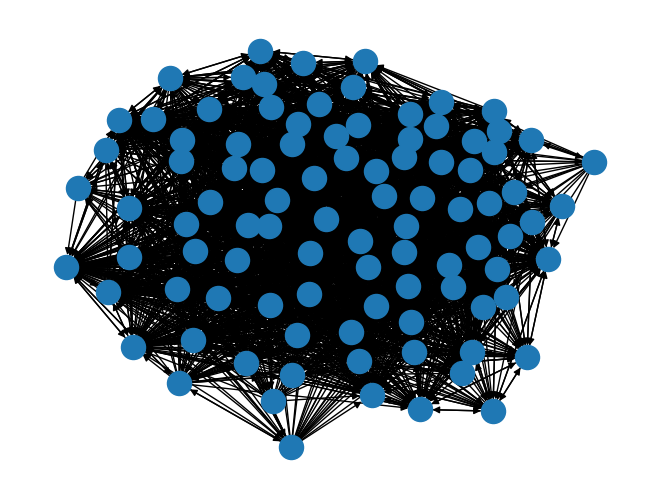

In [12]:
G = nx.from_pandas_adjacency(vmat, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
nx.draw(G, pos, arrows=True)

In [248]:
#Find the best partition of a graph using the Louvain Community Detection Algorithm.
louvain_communities = nx.community.louvain_communities(G, weight='weight', seed=123)

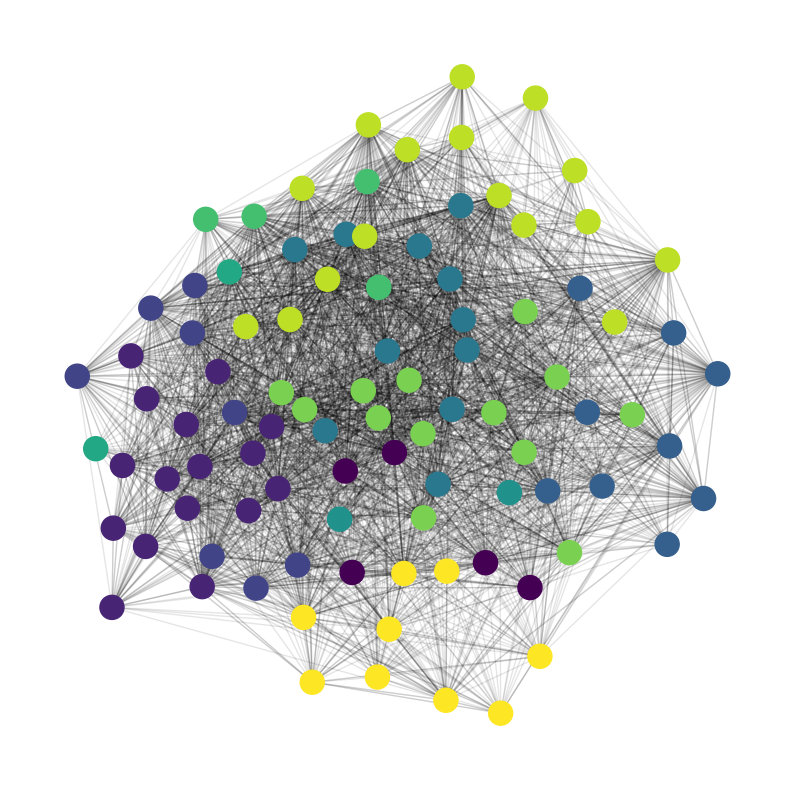

In [275]:
# Organize nodes by community
color_map = []
for node in G.nodes():
    for i, community in enumerate(louvain_communities):
        if node in community:
            color_map.append(i)

# Visualize
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)  # Adjust layout if needed
#nx.draw(G, pos, node_color=color_map, with_labels=False)
nx.draw_networkx_nodes(G, pos, node_color=color_map)
nx.draw_networkx_edges(G, pos, alpha=0.1, arrows=False)

plt.axis('off')
plt.show()

In [276]:
#how many communities?
print(len(louvain_communities))

11


In [246]:
#which are the diseases in each community?
for i, community in enumerate(louvain_communities):
    print(f'Community {i+1}: {community}')
    print(f'number of nodes {len(community)}')
    print()

Community 1: {'AHRQ_OthLowerRespiratoryDs_DT', 'AHRQ_COPDAndBronchiectasis_DT', 'AHRQ_Asthma_DT', 'AHRQ_RespiratoryInfections_DT', 'AHRQ_OthUpperRespiratoryDs_DT'}
number of nodes 5

Community 2: {'AHRQ_SystemicLupus_DT', 'AHRQ_DisOfWhiteBloodCells_DT', 'AHRQ_LiverDs_DT', 'AHRQ_RespiratoryFailure_DT', 'AHRQ_Pleurisy_DT', 'AHRQ_DisOfTheHeart_DT', 'AHRQ_DisOfArteries_DT', 'AHRQ_OthHematologicConditions_DT', 'AHRQ_DisOfTheUrinarySystem_DT', 'AHRQ_IntestinalInfection_DT', 'AHRQ_Anemia_DT', 'AHRQ_CoagulationDO_DT', 'AHRQ_PancreaticDO_DT', 'AHRQ_BiliaryTractDs_DT', 'AHRQ_FluidAndElectrolyteDO_DT', 'AHRQ_BacterialInfection_DT'}
number of nodes 16

Community 3: {'AHRQ_LowerGIDO_DT', 'AHRQ_GIHemorrhage_DT', 'AHRQ_UpperGIDO_DT', 'AHRQ_NoninfectiousGastroenterit0', 'AHRQ_DisOfVeins_DT', 'cancerdxDT', 'AHRQ_AbdominalHernia_DT', 'AHRQ_OthGIDO_DT'}
number of nodes 8

Community 4: {'AHRQ_OthConnectiveTissueDs_DT', 'AHRQ_Spondylosis_DT', 'AHRQ_NontraumaticJointDO_DT', 'anomdxDT', 'AHRQ_OthBoneDs_DT', 

In [ ]:
comm_dict = {'Community_1': 'Respiratory diseases',
             'Community_2': 'HEM/CIRC',
             'Community_3': 'gastrointestinal',
             'Community_4': 'MSK',
             'Community_5': 'Circulatory diseases',
             'Community_6': 'Mental disorders',
             'Community_7': 'Genitourinary diseases',
             'Community_8': 'Skin diseases',
             'Community_9': 'Musculoskeletal diseases',
             'Community_10': 'Nervous system diseases',
             'Community_11': 'Neoplasms'}
#controllare da 5 in poi

In [247]:
#values of communities modularity
modularity = nx.community.quality.modularity(G, louvain_communities, weight='weight')
print(f'Louvain Modularity: {modularity}')
partition = nx.community.quality.partition_quality(G, louvain_communities)
print(f'Partition: {partition}')


Louvain Modularity: 0.24196409517623563
Partition: (0.21354855781952897, 0.647592385218365)


{'Community_1': 'In: 77.11579358885521\nOut: 59.021554845191325', 'Community_2': 'In: 251.04101605940173\nOut: 378.22366840686965', 'Community_3': 'In: 122.43047782542537\nOut: 113.18799705348435', 'Community_4': 'In: 114.4957290802814\nOut: 98.54425258278816', 'Community_5': 'In: 250.12475662374277\nOut: 211.69793320125223', 'Community_6': 'In: 18.069038966525223\nOut: 43.518250087665464', 'Community_7': 'In: 28.329721140907562\nOut: 35.209314927122456', 'Community_8': 'In: 55.9471699324151\nOut: 49.33438997948593', 'Community_9': 'In: 338.92118715486043\nOut: 296.3943935806888', 'Community_10': 'In: 263.9869324431332\nOut: 211.15054763908628', 'Community_11': 'In: 56.67388490833579\nOut: 80.85340542024923'}


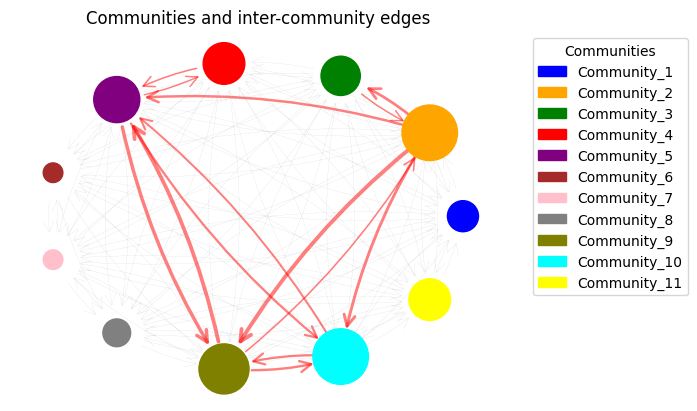

<Figure size 200000x180000 with 0 Axes>

In [125]:
import matplotlib.patches as mpatches
# ------------------------
# 2. Create 'Supernodes' and Calculate Strengths
# ------------------------

# Create a new graph for the supernodes
G_super = nx.DiGraph()

# Calculate strengths and add supernodes
for community_id, nodes in enumerate(louvain_communities):
    community_size = len(nodes)

    # In-strength: Sum of incoming weights to the community
    in_strength = sum(G.in_degree(node, weight='weight') for node in nodes)

    # Out-strength: Sum of outgoing weights from the community
    out_strength = sum(G.out_degree(node, weight='weight') for node in nodes)

    # Create a supernode representing the community
    G_super.add_node(f'Community_{community_id + 1}', size=community_size, 
                     in_strength=in_strength, out_strength=out_strength)

# ------------------------
# 3. Calculate Edge Weights for Supernodes 
# ------------------------

for u, v, data in G.edges(data=True):
    u_comm = next(i for i, comm in enumerate(louvain_communities) if u in comm)
    v_comm = next(i for i, comm in enumerate(louvain_communities) if v in comm)

    if u_comm != v_comm:  # Only consider edges between communities
        weight = data['weight']
        super_u = f'Community_{u_comm + 1}'
        super_v = f'Community_{v_comm + 1}'

        # Modification: Track inflows and outflows
        if G_super.has_edge(super_u, super_v):
            G_super[super_u][super_v]['weight'] += weight
        else:
            G_super.add_edge(super_u, super_v, weight=weight)
   
# ------------------------
# 4. Visualization
# ------------------------
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow'] 
color_map = dict(zip([f'Community_{i + 1}' for i in range(len(louvain_communities))], colors))


# Get positions for drawing (you might want a more sophisticated layout)
#pos = nx.spring_layout(G_super)
pos = nx.circular_layout(G_super)

# Draw communities with size based on their member count
node_sizes = [data['size'] * 100 for _, data in G_super.nodes(data=True)]
# Draw communities with assigned colors
node_colors = [color_map[node] for node in G_super.nodes()]
nx.draw_networkx_nodes(G_super, pos, node_size=node_sizes, node_color=node_colors) 


# Draw edges with width based on aggregated weight
edge_widths = []
for _, _, data in G_super.edges(data=True):
    if data['weight'] > (0.3*55):
        edge_widths.append(data['weight'] * 0.05)
    else:
        edge_widths.append(0.1)  
edge_color = []
for _, _, data in G_super.edges(data=True):
    if data['weight'] > (0.3*55):
        edge_color.append('red')
    else:
        edge_color.append('grey')    
#edge_widths = [data['weight'] * 0.04 for _, _, data in G_super.edges(data=True)]
nx.draw_networkx_edges(G_super, pos,width=edge_widths,edge_color= edge_color ,arrowstyle='->', arrowsize=20, 
                       alpha = 0.5,connectionstyle='arc3, rad = 0.1', min_source_margin= 20, min_target_margin= 20) #width=edge_widths,

# Add a legend
patches = [mpatches.Patch(color=color, label=community) for community, color in color_map.items()]
plt.legend(handles=patches, title='Communities',bbox_to_anchor=(1.04, 1), loc="upper left")
plt.axis('off')
plt.title('Communities and inter-community edges')
plt.figure(figsize=(2000,1800))
plt.show()


In [30]:
print(f"min edge weight: {min(G_super.edges(data=True), key=lambda x: x[2]['weight'])}")
print(f"max edge weight: {max(G_super.edges(data=True), key=lambda x: x[2]['weight'])}")

min edge weight: ('Community_4', 'Community_7', {'weight': 0.112645216471077})
max edge weight: ('Community_2', 'Community_9', {'weight': 55.57963715317364})


(array([34., 26., 13., 13.,  4.,  4.,  0.,  2.,  2.,  0.,  1.,  2.,  2.,
         0.,  1.,  1.,  0.,  1.,  0.,  2.]),
 array([ 0.11264522,  2.88599481,  5.65934441,  8.43269401, 11.2060436 ,
        13.9793932 , 16.7527428 , 19.52609239, 22.29944199, 25.07279159,
        27.84614118, 30.61949078, 33.39284038, 36.16618998, 38.93953957,
        41.71288917, 44.48623877, 47.25958836, 50.03293796, 52.80628756,
        55.57963715]),
 <BarContainer object of 20 artists>)

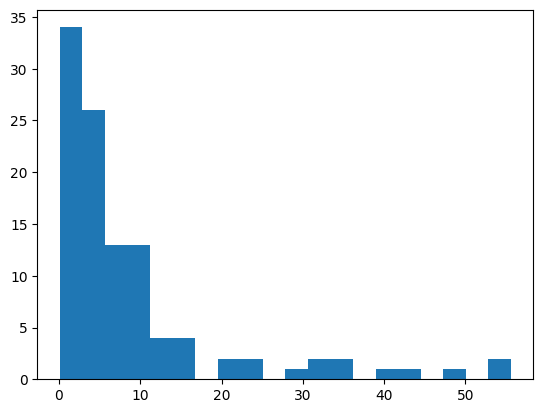

In [126]:
#plot distribution of edge weights
edge_weights = [data['weight'] for _, _, data in G_super.edges(data=True)]
plt.hist(edge_weights, bins=20)

In [198]:
#distribution of edge weights per community
in_strength_10 = {}
for data in G_super.edges(data=True):
    if data[1] == 'Community_10':
        in_strength_10.update({data[0]:data[2]['weight']})
print('In-strengths for Community_10:')
for k,v in sorted(in_strength_10.items(), key=lambda item: item[1]):
     print(k, v)

In-strengths for Community_10:
Community_6 2.2121001865153724
Community_7 3.935234472110493
Community_8 8.557401619728768
Community_1 8.831422403376582
Community_4 9.674792187761893
Community_3 12.098476197413824
Community_11 16.285854145293857
Community_5 32.72392675801114
Community_9 34.858697177418286
Community_2 41.85613779150463


In [199]:
in_strength_5 = {}
for data in G_super.edges(data=True):
    if data[1] == 'Community_5':
        in_strength_5.update({data[0]:data[2]['weight']})
print('In-strengths for Community_5:')
for k,v in sorted(in_strength_5.items(), key=lambda item: item[1]):
     print(k, v)

In-strengths for Community_5:
Community_11 3.0465021354336104
Community_7 5.946124720954919
Community_1 7.182602016347371
Community_3 7.862110843289826
Community_6 8.504993154236207
Community_8 10.0063030710053
Community_4 23.06122671871311
Community_10 28.865097453870423
Community_2 35.757014371033975
Community_9 54.13781225998574


In [200]:
in_strength_9 = {}
for data in G_super.edges(data=True):
    if data[1] == 'Community_9':
        in_strength_9.update({data[0]:data[2]['weight']})
print('In-strengths for Community_9:')
for k,v in sorted(in_strength_9.items(), key=lambda item: item[1]):
     print(k, v)

In-strengths for Community_9:
Community_7 2.762730852470118
Community_8 3.236776508865711
Community_1 3.638993019268768
Community_11 7.661915513187673
Community_3 9.722685139655237
Community_4 12.278196969991967
Community_6 13.597742353699369
Community_10 32.00658005625488
Community_5 49.63959706780091
Community_2 55.57963715317364


In [209]:
for i, community in enumerate(louvain_communities):
    match i:
        case 4:
            print(f'Community {i+1}: {community}')
        case 8:
            print(f'Community {i+1}: {community}')
        case 9:
            print(f'Community {i+1}: {community}')


Community 5: {'AHRQ_Burns_DT', 'AHRQ_InfectiveArthritis_DT', 'AHRQ_DOOfTeethAndJaw_DT', 'AHRQ_OthInjuriesExternalCauses_D', 'AHRQ_DisOfMouth_DT', 'AHRQ_EyeDO_DT', 'AHRQ_CrushingInjuryOrInternalIn0', 'AHRQ_SkinInfections_DT', 'AHRQ_SuperficialInjury_DT', 'AHRQ_Fractures_DT', 'AHRQ_OpenWounds_DT'}
Community 9: {'AHRQ_OthNervousSystemDO_DT', 'AHRQ_DevelopmentalDO_DT', 'AHRQ_ChronicUlcerOfSkin_DT', 'AHRQ_ComaBrainDamage_DT', 'AHRQ_Paralysis_DT', 'AHRQ_SpinalCordInjury_DT', 'AHRQ_Headache_DT', 'AHRQ_CNSInfection_DT', 'AHRQ_IntracranialInjury_DT', 'AHRQ_DementiaAndOthDO_DT', 'AHRQ_NSConditions_DT', 'AHRQ_CerebrovascularDs_DT', 'AHRQ_EpilepsyConvulsions_DT'}
Community 10: {'NEPEC_ANXgen_DT', 'AHRQ_SuicideAndSelfInjury_DT', 'NEPEC_MDD_DT', 'AHRQ_DOInChildhood_DT', 'NEPEC_DXDRG_DT', 'NEPEC_AFBPDX_DT', 'NEPEC_ANXunsp_DT', 'AHRQ_Poisoning_DT', 'AHRQ_AdjustmentDO_DT', 'NEPEC_DXALC_DT', 'AHRQ_PersonalityDO_DT', 'NEPEC_SCHZ_DT', 'NEPEC_PTSD_DT', 'NEPEC_DXODep_DT', 'AHRQ_AttentionDeficitDO_DT', 'AHRQ